In [1]:
from k1lib.imports import *

In [2]:
class Network(nn.Module):
    def __init__(self, hiddenDim=10, hiddenLayers=2, relu=True):
        super().__init__()
        activation = lambda: nn.LeakyReLU() if relu else nn.Sigmoid()
        layers = []
        layers += [nn.Linear(1, hiddenDim), activation()]
        for i in range(hiddenLayers):
            layers += [nn.Linear(hiddenDim, hiddenDim), activation()]
        layers += [nn.Linear(hiddenDim, 1)]
        self.bulk = nn.Sequential(*layers)
    def forward(self, x):
        return self.bulk(x)

In [3]:
# pretty much an exact copy of existing HookParam cb
class ParamData(k1lib.Object):
    def __init__(self, detachFirst):
        super().__init__()
        self.means = []; self.detachFirst = detachFirst
    def update(self, torchParam):
        if self.detachFirst: self.means.append(torchParam.detach().mean().item())
        else: self.means.append(torchParam.mean().item())
    def __len__(self): return len(self.means)
    def __repr__(self):
        return f"""Param's saved data. Use...
- d.means: to get list of means
- d.stds: to get list of means
- d.mins: to get list of mins
- d.maxs: to get list of maxs"""
class Param:
    def __init__(self, name, torchParam, detachFirst):
        self.name = name
        self.torchParam = torchParam
        self.data = ParamData(detachFirst)
    def update(self): self.data.update(self.torchParam)
    def __repr__(self):
        return f"""Param `{self.name}`. Use...
- p.torchParam: to get actual underlying parameter
- p.data: to get data stored
- cb.plot(): to quickly look at everything"""
@k1lib.patch(k1lib.Callback.cls)
class HookParam(k1lib.Callback):
    """Records means and stds of all parameters"""
    def __init__(self, detachFirst): super().__init__(); self.params = []; self.detachFirst = detachFirst
    def __getitem__(self, idx):
        if type(idx) == int: return self.params[idx]
        answer = HookParam(); answer.params = self.params[idx]; return answer
    def __len__(self): return len(self.params)
    def startRun(self):
        if len(self) == 0: # set things up first time only
            self.params = [Param(k, v, self.detachFirst) for k, v in self.model.named_parameters()]
    def startBatch(self): [param.update() for param in self.params]
    def __repr__(self):
        s = f", {len(self[0].data)} means and stds each" if len(self) > 0 else ""
        names = "\n".join([f"  {i}. {p.name}" for i, p in enumerate(self)])
        return f"""{super()._reprHead}: {len(self)} params{s}:\n{names}\n
Use...
- cb.plot(): to quickly look at everything
- cb[i]: to view a single param
- cb[a:b]: to get a new HookParam with selected params
{super()._reprCan}"""
@k1lib.patch(k1lib.Callbacks)
def withHookParam(self, detachFirst=True): return self.append(HookParam(detachFirst))

In [4]:
def newL(bs=64, optF=None, hiddenDim=10, simple=True, detachFirst=True):
    if optF == None: optF = lambda x: optim.SGD(x, lr=2e-4, momentum=0.9)
    if optF == "Adam": optF = lambda p: optim.Adam(p, lr=1e-2)
    l = k1lib.Learner()
    l.model = Network(hiddenDim=hiddenDim)
    l.data = k1lib.data.Data.fromDataset(k1lib.data.FunctionDataset.exp, bs)
    l.opt = optF(l.model.parameters())
    l.lossF = lambda x, y: ((x.squeeze() - y)**2).mean()
    #l.lossF = lambda x, y: (x**2).mean()
    if simple: l.cbs = k1lib.Callbacks().withProgressBar().append(HookParam(detachFirst))
    l.cbs.withModifyBatch(lambda x, y: (x[:, None], y))
    l.cbs.withDType(torch.float32);
    def evaluate(self):
        xbs, ybs, ys = self.record(1, 3)
        xbs = torch.vstack(xbs).squeeze()
        ybs = torch.vstack([yb[:, None] for yb in ybs]).squeeze()
        ys = torch.vstack(ys).squeeze()
        #plt.plot(xbs, ybs, ".")
        plt.plot(xbs, ys.detach(), ".")
    l.evaluate = partial(evaluate, l)
    #l.cbs.withCancelOnLowLoss(1, epochMode=True)
    return l

In [7]:
hs = [elem for elem in range(10, 100) for i in range(10)]
elapsedTimes = []
for h in hs:
    l = newL(optF="Adam", hiddenDim=h, detachFirst=True)
    l.run(1);
    elapsedTimes.append(l.elapsedTime)
with open("detachFirst.pth", "wb") as f: pickle.dump(k1lib.Object.fromDict({"hs": hs, "elapsedTimes": elapsedTimes}), f)

Progress:  74%, epoch: 0/1, batch:   23/31, elapsed:   0.29s  

In [6]:
hs = [elem for elem in range(10, 100) for i in range(10)]
elapsedTimes = []
for h in hs:
    l = newL(optF="Adam", hiddenDim=h, detachFirst=False)
    l.run(1);
    elapsedTimes.append(l.elapsedTime)
with open("detachSecond.pth", "wb") as f: pickle.dump(k1lib.Object.fromDict({"hs": hs, "elapsedTimes": elapsedTimes}), f)

Progress:  74%, epoch: 0/1, batch:   23/31, elapsed:   0.28s  

## Analysis

This is pretty much exactly the same setup as feature-elapsedTime, but just to measure a specific feature

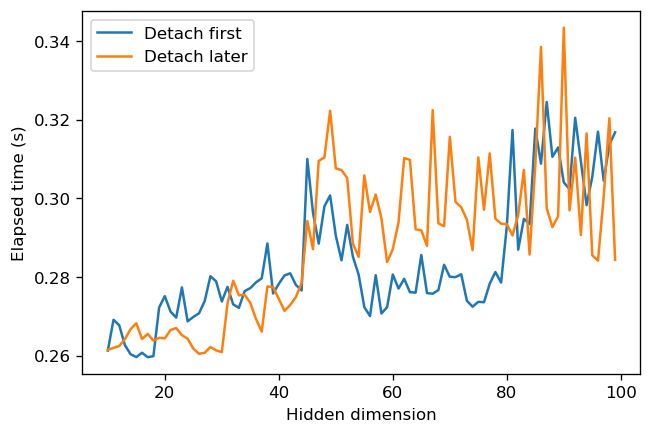

In [11]:
with open("detachFirst.pth", "rb") as f: data1 = pickle.load(f)
with open("detachSecond.pth", "rb") as f: data2 = pickle.load(f)
plt.figure(dpi=120); plt.xlabel("Hidden dimension"); plt.ylabel("Elapsed time (s)")
smooth = 10
plt.plot(k1lib.smooth(data1.hs, smooth), k1lib.smooth(data1.elapsedTimes, smooth));
plt.plot(k1lib.smooth(data2.hs, smooth), k1lib.smooth(data2.elapsedTimes, smooth));
plt.legend(["Detach first", "Detach later"]);

Yeah not totally sure which is better actually. Raw data below:

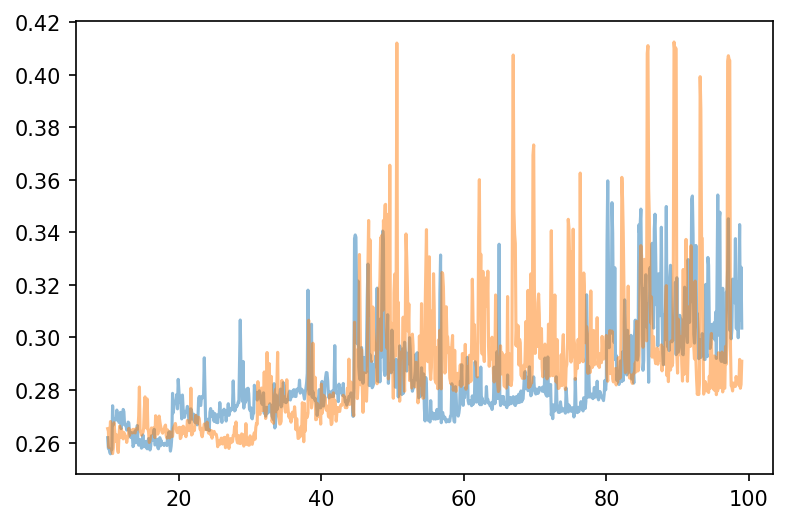

In [21]:
plt.figure(dpi=150); x = np.linspace(data1.hs[0], data1.hs[-1], len(data1.hs))
plt.plot(x, data1.elapsedTimes, alpha=0.5)
plt.plot(x, data2.elapsedTimes, alpha=0.5)